In [1]:
!pip install opencv-python pandas scikit-image simpleitk torchxrayvision matplotlib openpyxl

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchxrayvision as xrv
import SimpleITK as sitk
from skimage import exposure
from skimage.exposure import match_histograms
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# ================= Config =================
ROOT_DIR = "Chest xray CP class"
OUTPUT_DIR = "Notebook_Stable_Output" # เปลี่ยนชื่อโฟลเดอร์ผลลัพธ์
CLASSES = ["novap", "vap"]
CHANGE_THRESHOLD = 25

if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
print(f"✅ Config Loaded.")

# Load AI
print("⏳ Loading AI Model...")
seg_model = xrv.baseline_models.chestx_det.PSPNet()
seg_model.eval()
print("✅ AI Model Loaded!")

# Image Enhancements
def enhance_contrast(image_arr: np.ndarray, clip_limit: float = 0.03):
    return exposure.equalize_adapthist(image_arr, clip_limit=clip_limit)

def apply_medical_enhancement(img_uint8):
    img_float = img_uint8.astype(np.float32) / 255.0
    enhanced_float = enhance_contrast(img_float, clip_limit=0.03)
    return (enhanced_float * 255).astype(np.uint8)

# AI Mask Function
def get_ai_lung_mask(img_numpy_uint8):
    try:
        img_norm = xrv.datasets.normalize(img_numpy_uint8, 255) 
        img_resized = cv2.resize(img_norm, (512, 512))
        img_tensor = torch.from_numpy(img_resized)[None, None, ...].float()
        with torch.no_grad(): outputs = seg_model(img_tensor)
        pred = outputs[0].numpy()
        combined_mask = np.maximum(pred[4], pred[5])
        mask_binary = np.where(combined_mask > 0.5, 255, 0).astype(np.uint8)
        h, w = img_numpy_uint8.shape
        mask_final = cv2.resize(mask_binary, (w, h), interpolation=cv2.INTER_NEAREST)
        kernel = np.ones((5,5), np.uint8)
        mask_final = cv2.morphologyEx(mask_final, cv2.MORPH_CLOSE, kernel, iterations=3)
        return mask_final
    except: return np.zeros_like(img_numpy_uint8)

c:\Users\b33rt\OneDrive\Desktop\CP xray\Chest xray CP class-20251205T165553Z-3-001\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Config Loaded.
⏳ Loading AI Model...
✅ AI Model Loaded!


In [3]:
def robust_registration_stable(im_fixed, im_moving):
    """
    [New] ดึงภาพให้ตรงกันแบบเสถียร (Stable Rigid Registration)
    ห้ามบิดภาพ (No Shear/Scaling) อนุญาตแค่ หมุน และ เลื่อน เท่านั้น
    """
    h, w = im_fixed.shape
    
    # 1. ใช้ภาพ Enhance เพื่อให้เห็นโครงสร้างกระดูกชัดขึ้น
    im_fixed_enh = apply_medical_enhancement(im_fixed)
    im_moving_enh = apply_medical_enhancement(im_moving)
    
    # 2. เบลอภาพเล็กน้อย เพื่อลด Noise และให้ ECC โฟกัสที่โครงสร้างหลักๆ (เช่น กระดูกสันหลัง/ซี่โครง)
    im_fixed_blur = cv2.GaussianBlur(im_fixed_enh, (5, 5), 0)
    im_moving_blur = cv2.GaussianBlur(im_moving_enh, (5, 5), 0)

    # --- หัวใจสำคัญ: กำหนดโหมดเป็น MOTION_EUCLIDEAN (Rigid) ---
    # โหมดนี้จะล็อคไม่ให้ภาพยืดหด หรือบิดเบี้ยวผิดรูป
    warp_mode = cv2.MOTION_EUCLIDEAN
    warp_matrix = np.eye(2, 3, dtype=np.float32) # เริ่มต้นด้วย Identity matrix

    # ตั้งค่าการทำงานของ ECC
    number_of_iterations = 500 # เพิ่มจำนวนรอบเผื่อเคสยากๆ
    termination_eps = 1e-5
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

    try:
        print("   Trying Rigid ECC Alignment...")
        # คำนวณหา Matrix การหมุน/เลื่อน
        (cc, warp_matrix) = cv2.findTransformECC(im_fixed_blur, im_moving_blur, warp_matrix, warp_mode, criteria)
        
        # นำ Matrix ที่ได้มาใช้กับภาพจริง
        # ใช้ WARP_INVERSE_MAP เพราะ ECC คำนวณแบบ inverse
        aligned = cv2.warpAffine(im_moving, warp_matrix, (w, h), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        print(f"   -> Success (Correlation: {cc:.3f})")
        return aligned, "Rigid-ECC"
        
    except Exception as e:
        # ถ้า ECC หาทางลงไม่ได้ ให้ใช้ภาพเดิมดีกว่าภาพเบี้ยว
        print(f"   -> Alignment diverged or failed. Using original. Reason: {e}")
        # Resize ให้เท่ากันเผื่อไว้
        return cv2.resize(im_moving, (w, h)), "Fail (Original Used)"

In [4]:
def analyze_and_plot(img_path1, img_path2, patient_id, date1, date2, output_subfolder):
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None: return None
    
    h, w = img1.shape
    img2 = cv2.resize(img2, (w, h))
    img1_show = apply_medical_enhancement(img1)
    
    # --- เรียกใช้ฟังก์ชันใหม่ที่เสถียรกว่า ---
    img2_aligned, method = robust_registration_stable(img1, img2)

    # Histogram Match & Enhancement for display
    img2_matched = match_histograms(img2_aligned, img1).astype('uint8')
    img2_matched_show = apply_medical_enhancement(img2_matched)

    # AI Segmentation
    lung_mask = get_ai_lung_mask(img1)
    
    # Subtraction Analysis
    diff_worse = cv2.subtract(img2_matched, img1)
    diff_worse = cv2.bitwise_and(diff_worse, diff_worse, mask=lung_mask)
    _, mask_worse = cv2.threshold(diff_worse, CHANGE_THRESHOLD, 255, cv2.THRESH_BINARY)
    
    diff_better = cv2.subtract(img1, img2_matched)
    diff_better = cv2.bitwise_and(diff_better, diff_better, mask=lung_mask)
    _, mask_better = cv2.threshold(diff_better, CHANGE_THRESHOLD, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3,3), np.uint8)
    mask_worse = cv2.morphologyEx(mask_worse, cv2.MORPH_OPEN, kernel)
    mask_better = cv2.morphologyEx(mask_better, cv2.MORPH_OPEN, kernel)

    lung_px = cv2.countNonZero(lung_mask)
    if lung_px == 0: lung_px = 1
    worse_pct = (cv2.countNonZero(mask_worse) / lung_px) * 100
    better_pct = (cv2.countNonZero(mask_better) / lung_px) * 100
    
    status = "Stable"
    if worse_pct > 3.0 and worse_pct > better_pct: status = "Worsening"
    elif better_pct > 3.0 and better_pct > worse_pct: status = "Improving"

    # Visualization
    result_visual = cv2.cvtColor(img2_matched_show, cv2.COLOR_GRAY2BGR)
    result_visual[mask_worse > 0] = [255, 0, 0] 
    result_visual[(mask_better > 0) & (mask_worse == 0)] = [0, 255, 0] 
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(result_visual, contours, -1, (255, 255, 0), 2)
    final_rgb = cv2.addWeighted(cv2.cvtColor(img1_show, cv2.COLOR_GRAY2RGB), 0.5, result_visual, 0.5, 0)
    
    filename = f"{patient_id}_{date1}_vs_{date2}.jpg"
    save_path = os.path.join(output_subfolder, filename)
    cv2.imwrite(save_path, cv2.cvtColor(final_rgb, cv2.COLOR_RGB2BGR))

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title(f"Day 1 (AI Mask)"); plt.imshow(lung_mask, cmap='gray'); plt.axis('off')
    # รูปตรงกลางนี้สำคัญ คือรูป Day 2 ที่ถูกดึงให้ตรงแล้ว
    plt.subplot(1, 3, 2); plt.title(f"Day 2 (Rigid Aligned)"); plt.imshow(img2_matched_show, cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title(f"Result: {status}\nNew: {worse_pct:.1f}%"); plt.imshow(final_rgb); plt.axis('off')
    plt.tight_layout(); plt.show()

    return { "Patient_ID": patient_id, "Dates": f"{date1} vs {date2}", "Status": status, "New_Lesion(%)": round(worse_pct, 2), "Improved(%)": round(better_pct, 2), "Method": method }

🚀 Starting Analysis... (Check images below)

--- Processing Patient: 2268 (novap) ---
   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.453)


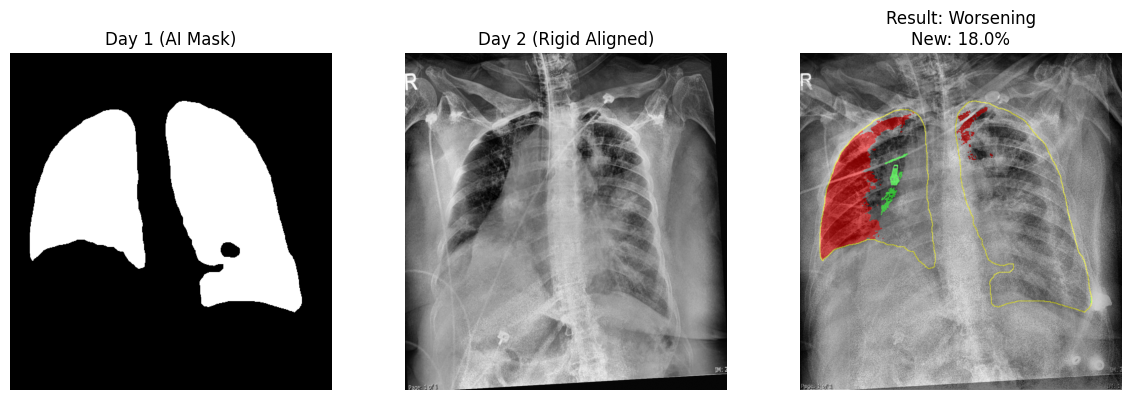

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.519)


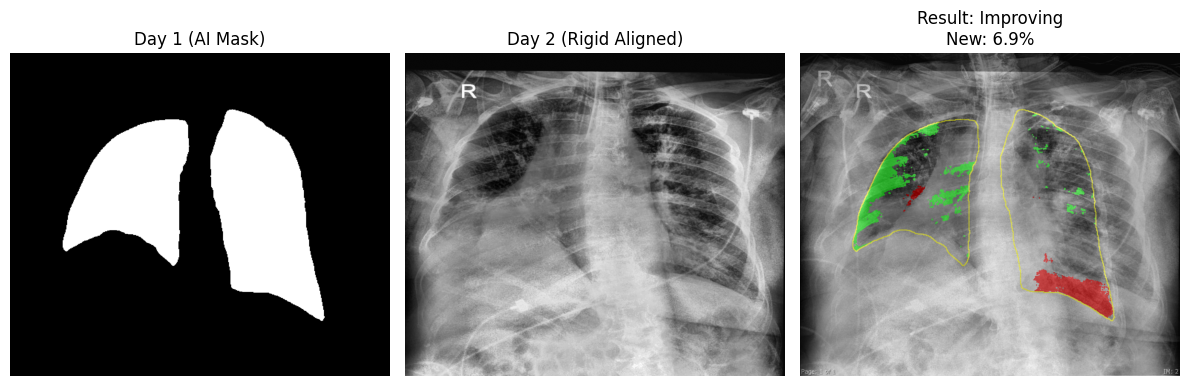

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.491)


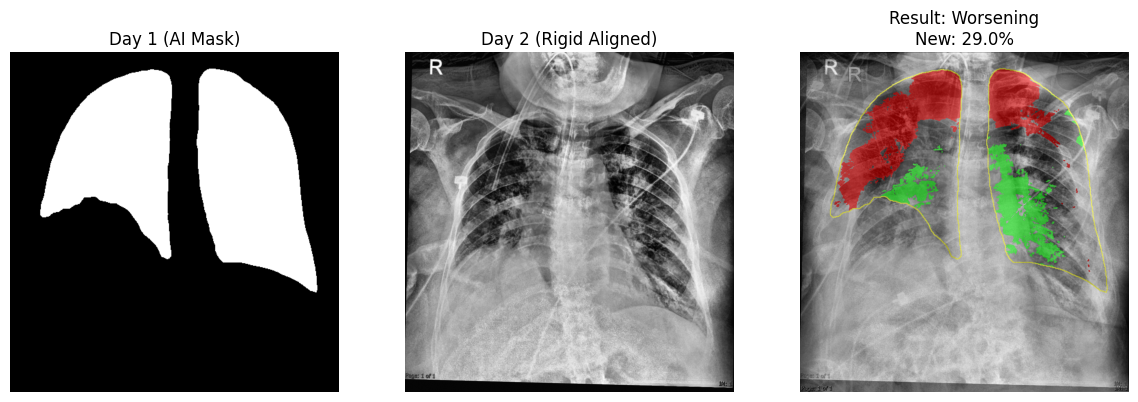

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.574)


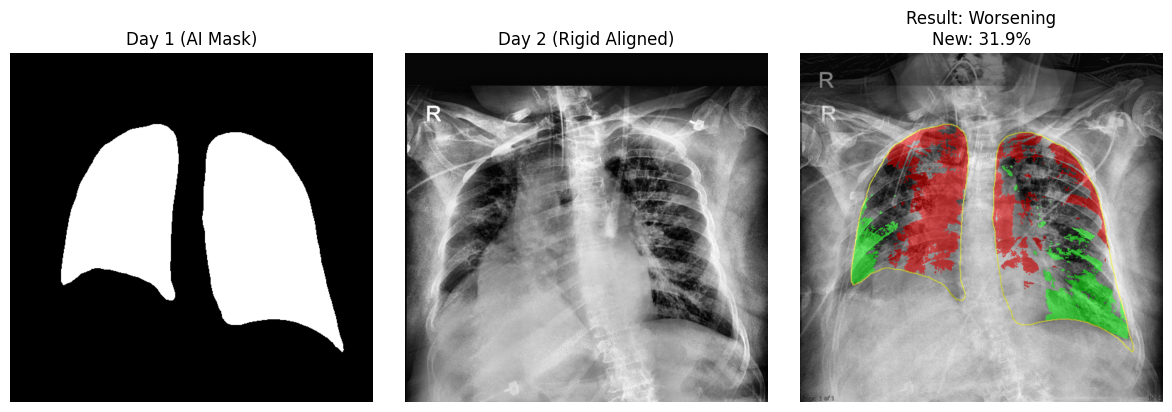

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.658)


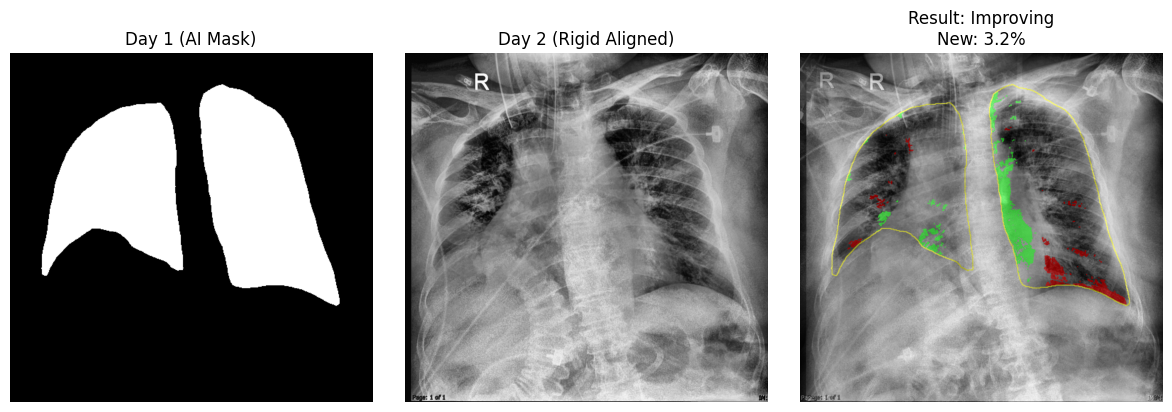

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.565)


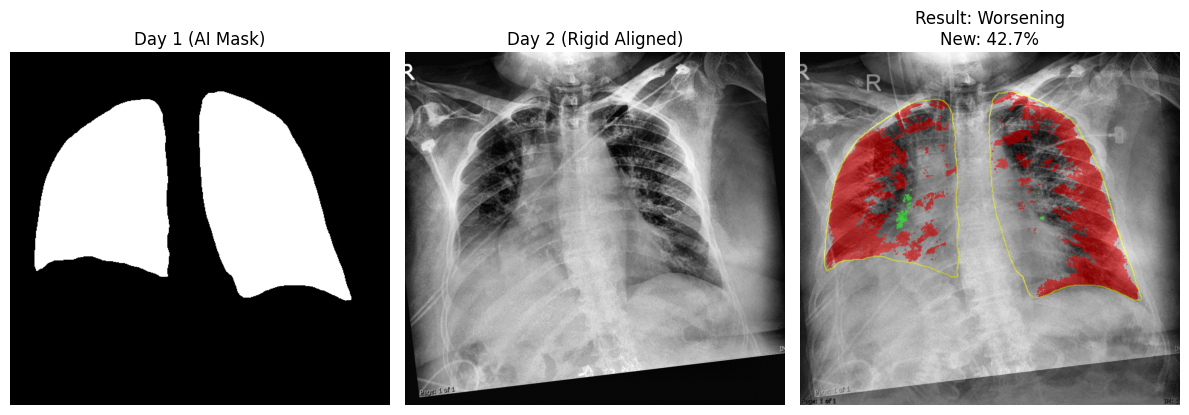

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.463)


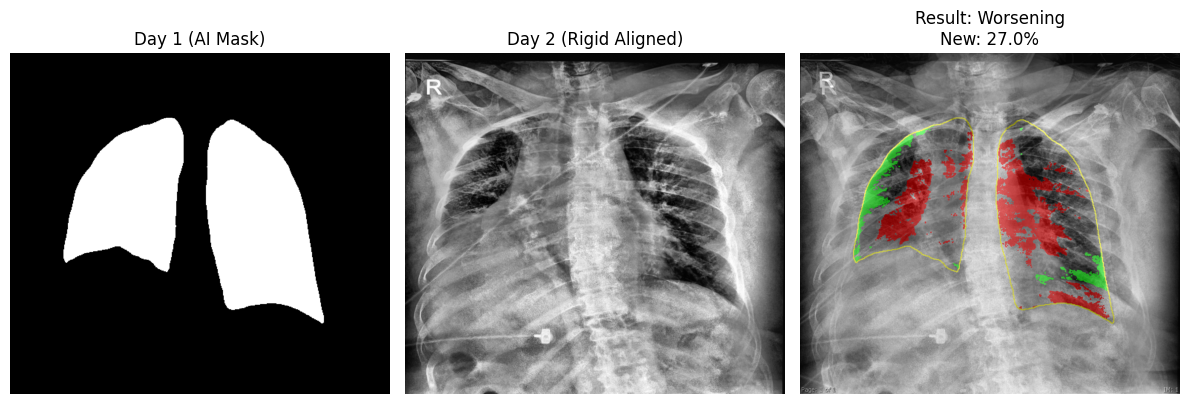

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.367)


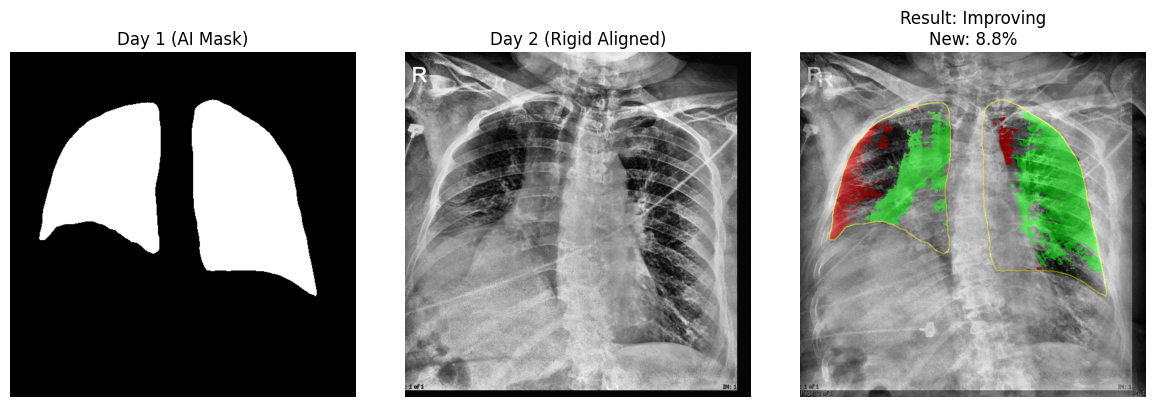

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.533)


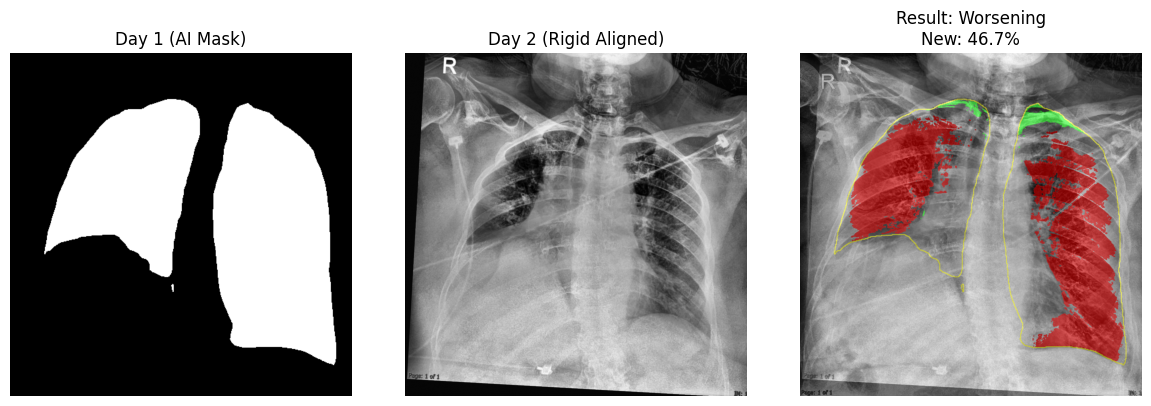


--- Processing Patient: 2272 (novap) ---
   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.579)


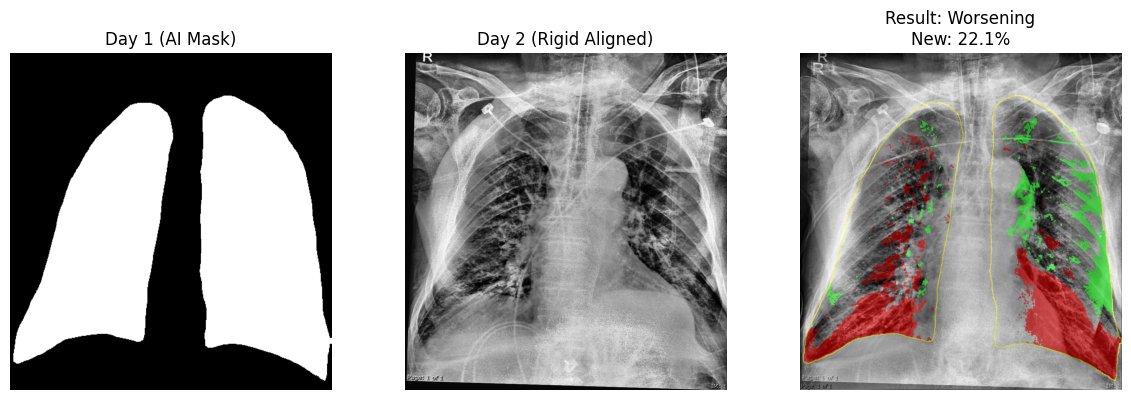

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.551)


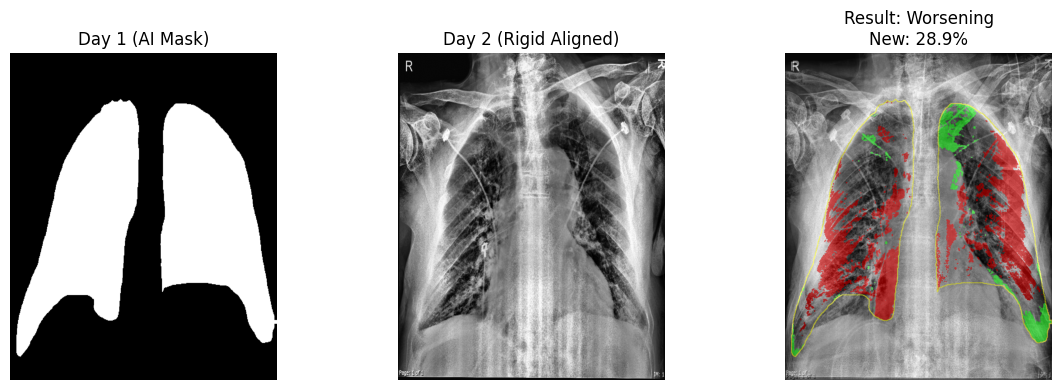

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.658)


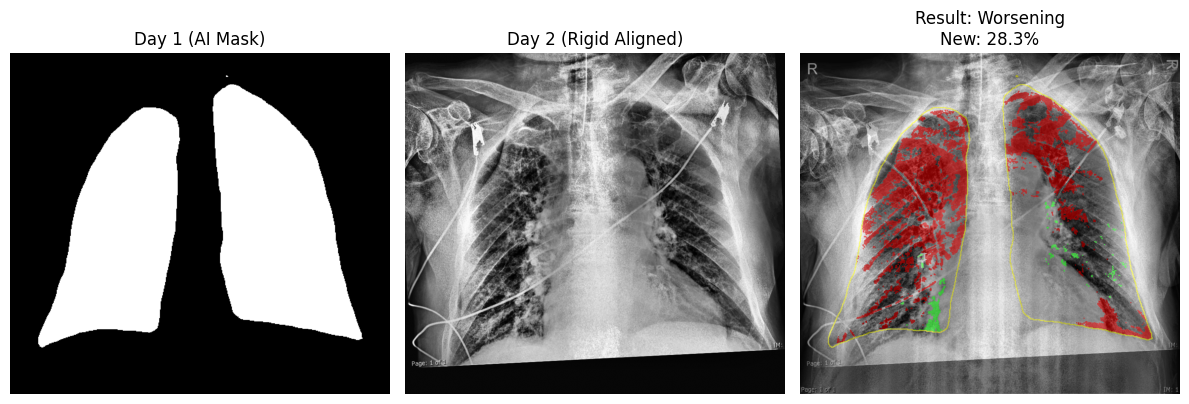

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.461)


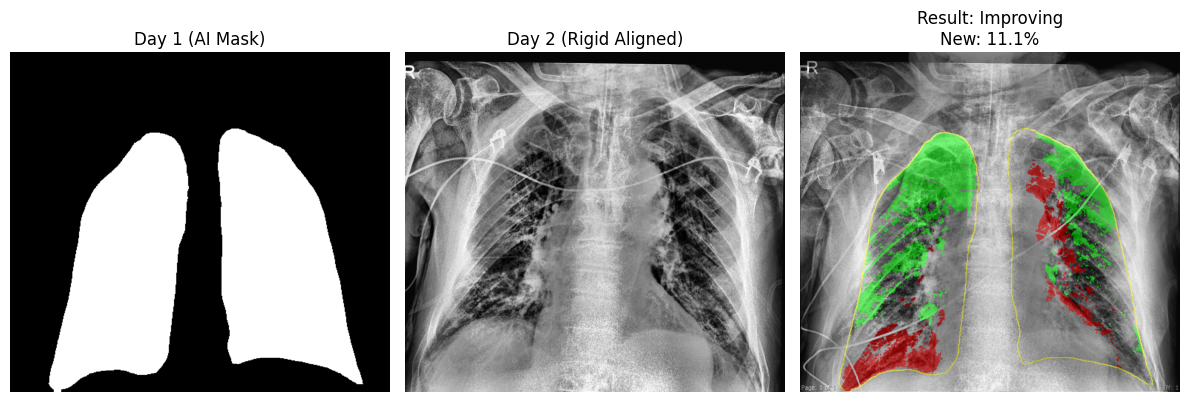

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.401)


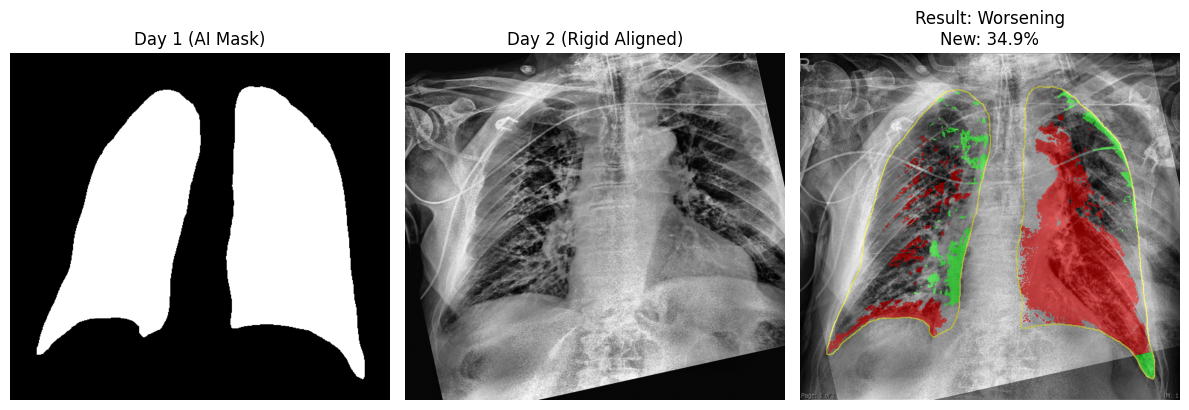

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.363)


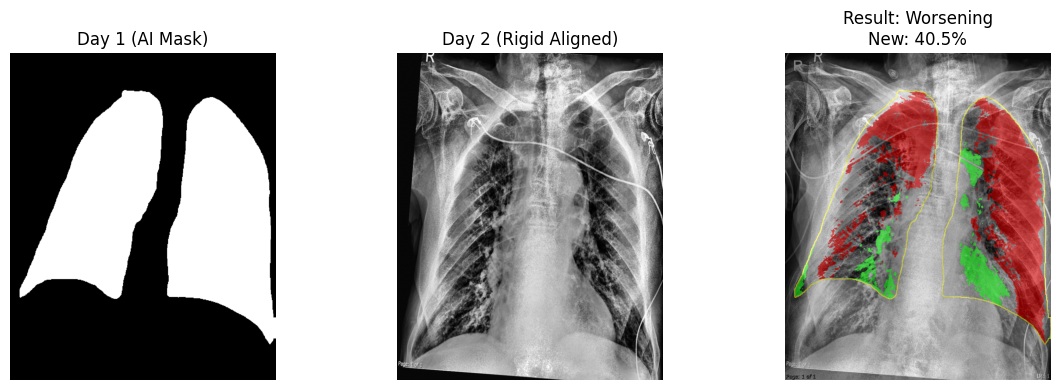

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.536)


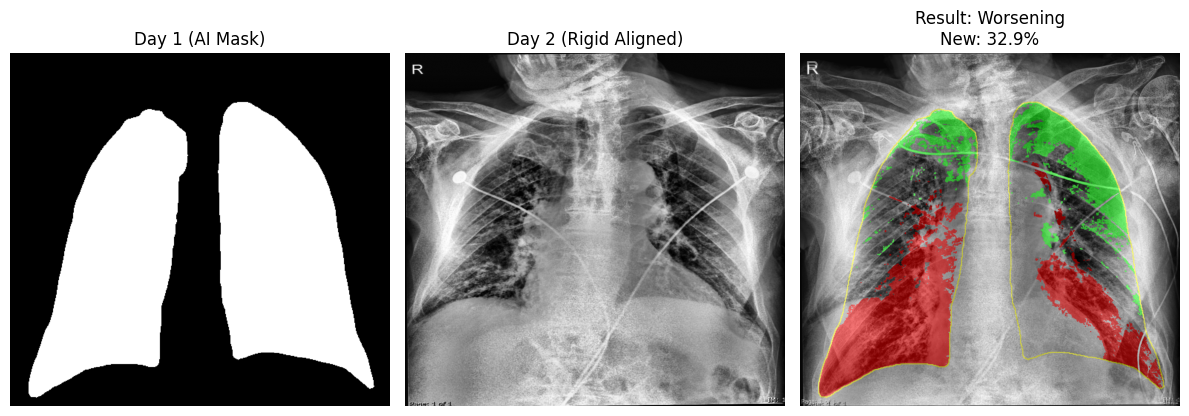

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.631)


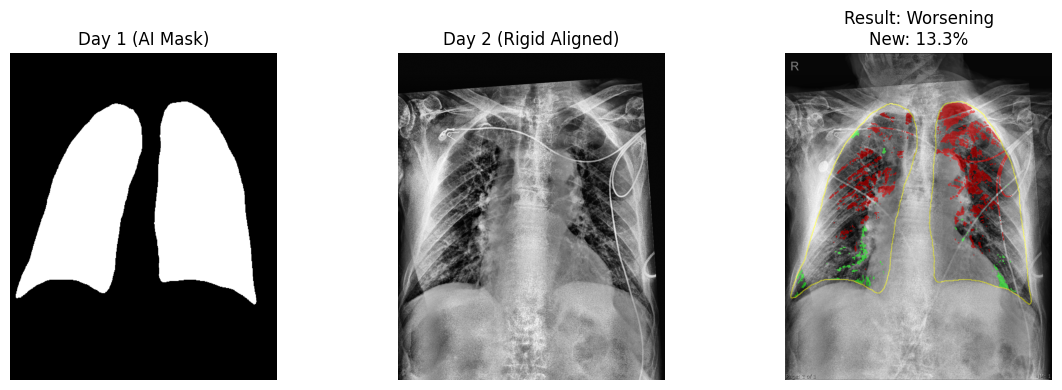

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.249)


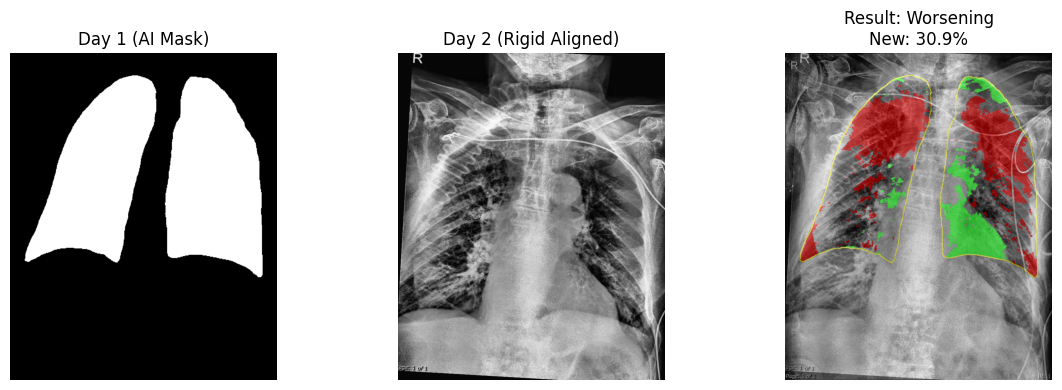

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.631)


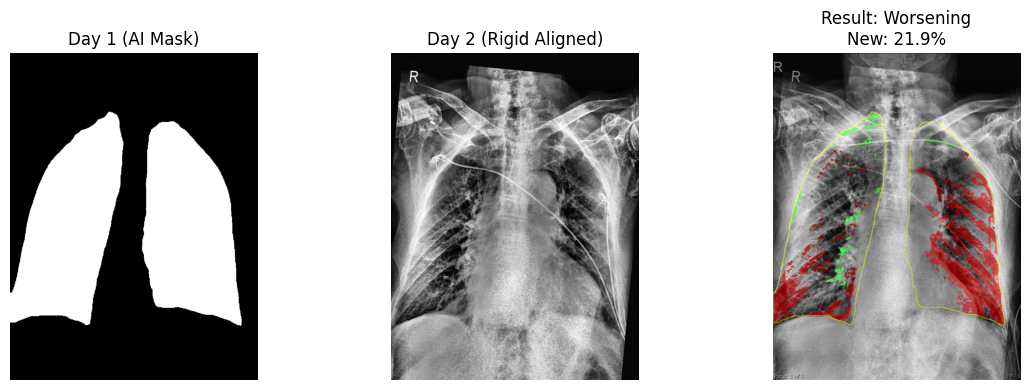

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.569)


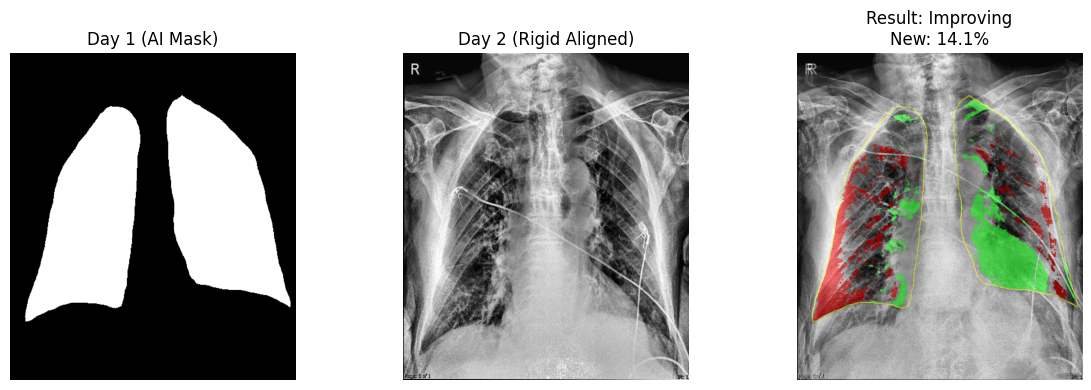

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.542)


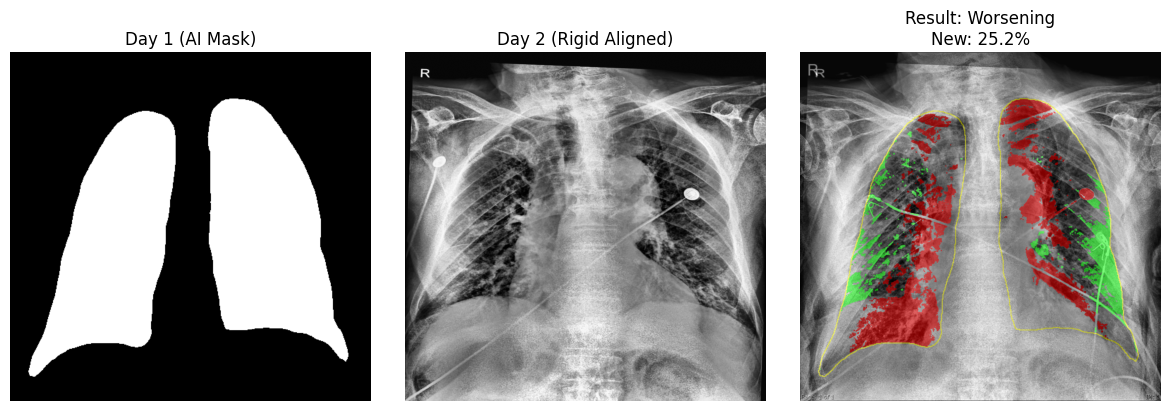

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.620)


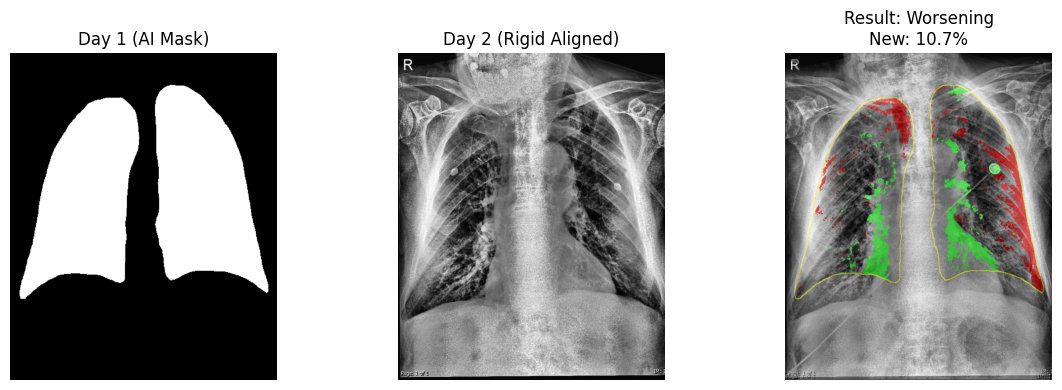

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.600)


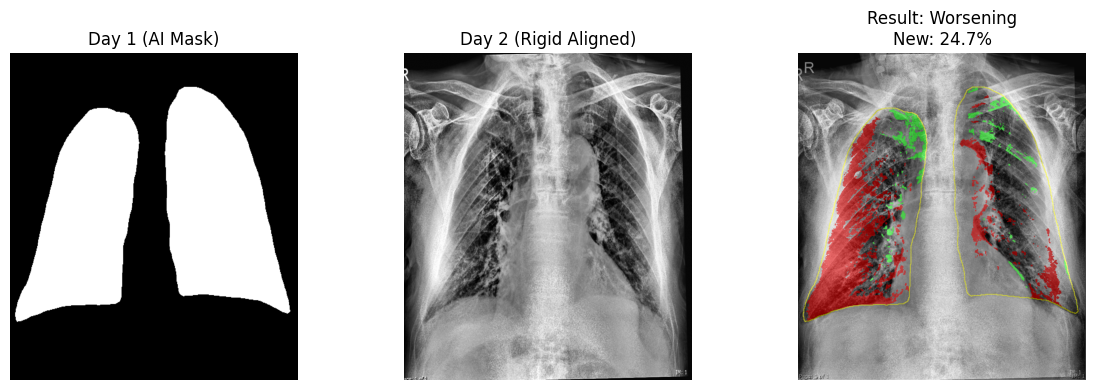

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.383)


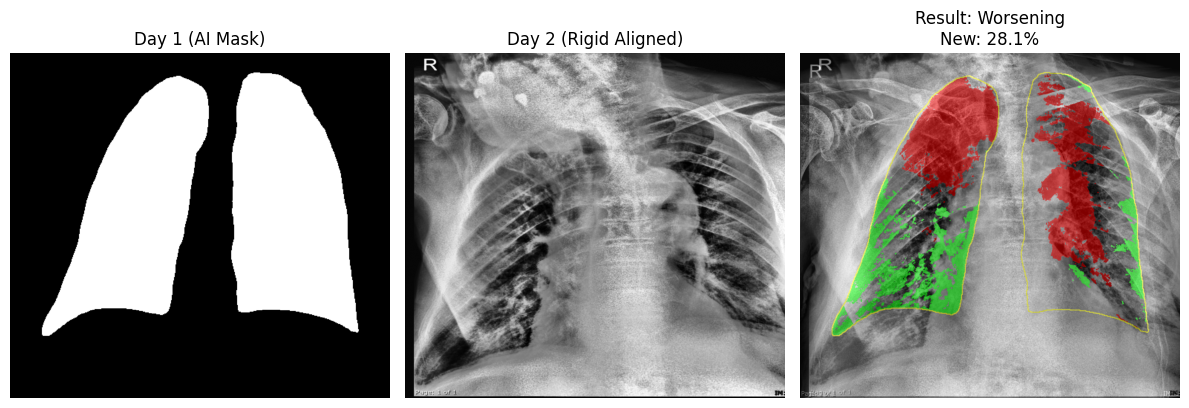

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.364)


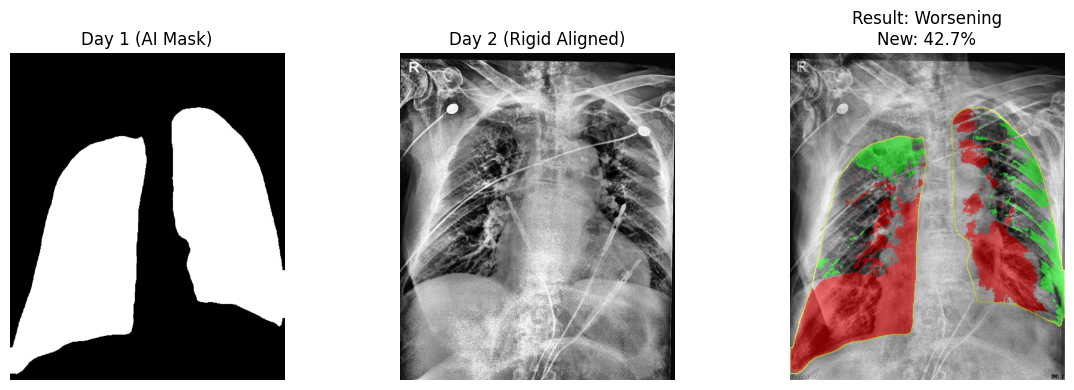

   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.529)


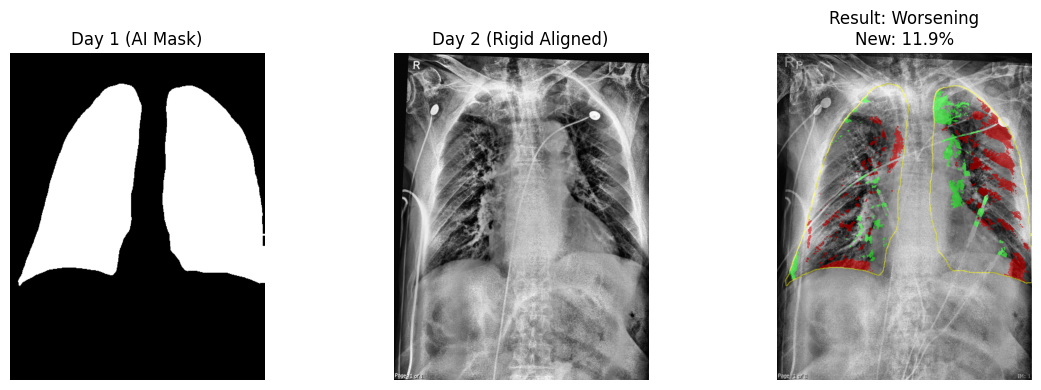


--- Processing Patient: 2273 (novap) ---
   Trying Rigid ECC Alignment...
   -> Success (Correlation: 0.238)


In [ ]:
def parse_info(filename):
    try:
        parts = filename.replace(".jpg", "").split("_")
        return datetime.strptime(parts[-2], "%Y%m%d"), int(parts[-1])
    except: return None, None

def get_valid_image_sequence(folder_path):
    if not os.path.exists(folder_path): return []
    files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
    daily = {}
    for f in files:
        d, s = parse_info(f)
        if d and (d not in daily or s > daily[d][0]): daily[d] = (s, f)
    return [daily[d][1] for d in sorted(daily.keys())]

# --- MAIN Execution ---
report = []
print(f"🚀 Starting Analysis... (Check images below)")

for cls in CLASSES:
    c_path = os.path.join(ROOT_DIR, cls)
    if not os.path.exists(c_path): continue
    
    for pid in os.listdir(c_path):
        p_path = os.path.join(c_path, pid)
        if not os.path.isdir(p_path): continue
        
        files = get_valid_image_sequence(p_path)
        if len(files) < 2: continue
        
        save_dir = os.path.join(OUTPUT_DIR, cls, pid)
        if not os.path.exists(save_dir): os.makedirs(save_dir)
        
        print(f"\n--- Processing Patient: {pid} ({cls}) ---")
        
        for i in range(len(files)-1):
            f1, f2 = files[i], files[i+1]
            d1, _ = parse_info(f1)
            d2, _ = parse_info(f2)
            
            res = analyze_and_plot(
                os.path.join(p_path, f1), 
                os.path.join(p_path, f2),
                pid, d1.date(), d2.date(), save_dir
            )
            if res: report.append(res)

if report:
    df = pd.DataFrame(report)
    df.to_excel(os.path.join(OUTPUT_DIR, "Notebook_Report.xlsx"), index=False)
    print("\n✅ Analysis Complete. Report saved.")
else:
    print("\n⚠️ No valid data found.")